#### Importing required Libraries

In [ ]:
import numpy as np
import pandas as pd
from itertools import groupby
import gc

In [ ]:
# Reading dataset
dataset = pd.read_parquet("Zzzs_train.parquet")

In [ ]:
# Checking the initial 5 rows of the dataset
dataset.head()

,series_id,step,timestamp,anglez,enmo,awake
0,08db4255286f,0,2018-11-05T10:00:00-0400,-30.845301,0.0447,1
1,08db4255286f,1,2018-11-05T10:00:05-0400,-34.181801,0.0443,1
2,08db4255286f,2,2018-11-05T10:00:10-0400,-33.877102,0.0483,1
3,08db4255286f,3,2018-11-05T10:00:15-0400,-34.282101,0.0680,1
4,08db4255286f,4,2018-11-05T10:00:20-0400,-34.385799,0.0768,1


#### Feature engineering

Converting the data timestamp into datetime type so that we can extract hour

In [ ]:
def make_features(df):

    df['timestamp'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))
    df["hour"] = df["timestamp"].dt.hour

    periods = 20
    df["anglez"] = abs(df["anglez"])
    df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill").astype('float16')
    df["enmo_diff"] = df.groupby('series_id')['enmo'].diff(periods=periods).fillna(method="bfill").astype('float16')
    df["anglez_rolling_mean"] = df["anglez"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_rolling_mean"] = df["enmo"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_rolling_max"] = df["anglez"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_rolling_max"] = df["enmo"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_rolling_std"] = df["anglez"].rolling(periods,center=True).std().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_rolling_std"] = df["enmo"].rolling(periods,center=True).std().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_diff_rolling_mean"] = df["anglez_diff"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_diff_rolling_mean"] = df["enmo_diff"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_diff_rolling_max"] = df["anglez_diff"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_diff_rolling_max"] = df["enmo_diff"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')

    return df

features = ["hour",
            "anglez",
            "anglez_rolling_mean",
            "anglez_rolling_max",
            "anglez_rolling_std",
            "anglez_diff",
            "anglez_diff_rolling_mean",
            "anglez_diff_rolling_max",
            "enmo",
            "enmo_rolling_mean",
            "enmo_rolling_max",
            "enmo_rolling_std",
            "enmo_diff",
            "enmo_diff_rolling_mean",
            "enmo_diff_rolling_max",
           ]

#### Training

In [ ]:
df   = make_features(dataset)

In [ ]:
all_series = df.series_id.unique()
train_series = all_series[:28]
test_series = all_series[30:35]

train_data = df[df['series_id'].isin(train_series)]
test_data = df[df['series_id'].isin(test_series)]

X_train = train_data[features]
y_train = train_data["awake"]
X_test = test_data[features]
y_test = test_data["awake"]

In [ ]:
# save some memory
del df
gc.collect();

#### Random Forest Model

In [ ]:
%%time

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=50,
                                    min_samples_leaf=300,
                                    random_state=42,n_jobs=-1)

classifier.fit(X_train, y_train)

CPU times: user 1h 31min 50s, sys: 36.8 s, total: 1h 32min 27s
Wall time: 24min 28s


RandomForestClassifier(min_samples_leaf=300, n_estimators=50, n_jobs=-1,
                       random_state=42)

In [ ]:
classifier

RandomForestClassifier(min_samples_leaf=300, n_estimators=50, n_jobs=-1,
                       random_state=42)

In [ ]:
from sklearn import metrics

y_test_pred = classifier.predict(X_test)
metrics.accuracy_score(y_test, y_test_pred)

0.9612693636464951

#### ROC Curve

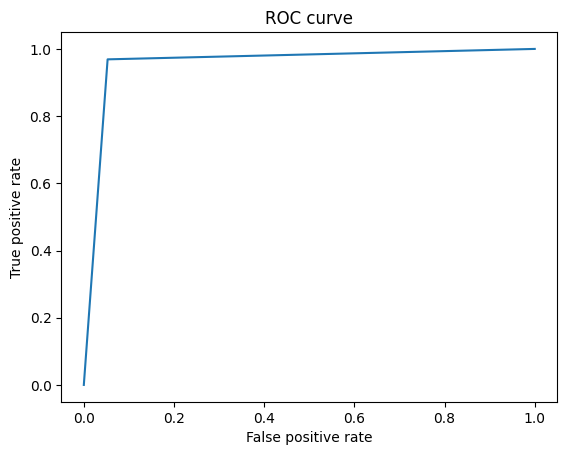

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.show()


#### Saving model

In [ ]:
import pickle

In [ ]:
filename = 'finalized_model.sav'
pickle.dump(classifier, open(filename, 'wb'))

In [ ]:
from IPython.display import FileLink

In [ ]:
FileLink('finalized_model.sav')

/kaggle/working/finalized_model.sav